In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

4276


In [2]:
import cv2

In [3]:
data_folder = r'\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors'

folders, fovs = ia.io_tools.data.get_folders(data_folder)


Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 11
- Number of field of views: 168


In [4]:
correction_folder = r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20210621-Corrections_lumencor_from_60_to_50'

segmentation_save_folder = os.path.join(data_folder, 'Segmentation')
if not os.path.exists(segmentation_save_folder):
    os.makedirs(segmentation_save_folder)
from cellpose import models

from ImageAnalysis3.segmentation_tools.cell import Align_Segmentation
reload(ia.segmentation_tools.cell)

# transpose with microscope
microscope_file = r'\\mendel\pu_documents\Merfish_analysis\Merfish_Analysis_Scripts\merlin_parameters\microscope\storm6_microscope.json'
microscope_params = Align_Segmentation._read_microscope_json(microscope_file)
microscope_params

{'flip_horizontal': False,
 'flip_vertical': True,
 'transpose': True,
 'microns_per_pixel': 0.108}

In [9]:

for _fov_id, _fov_name in enumerate(fovs):
    
    seg_save_file = os.path.join(segmentation_save_folder, f'segmentation_label_{_fov_id}.npy')
    if os.path.exists(seg_save_file):
        continue

    dapi_image_file = os.path.join(folders[0], _fov_name)
    print(dapi_image_file)
    # load reference DAPI
    _ref_cls = ia.classes.preprocess.DaxProcesser(dapi_image_file, 
                                                 CorrectionFolder=correction_folder, DriftChannel=488, DapiChannel=405)
    _ref_cls._load_image(sel_channels=[561,405])
    _ref_cls._corr_illumination()

    # cellpose
    print(f"- apply microscope corrections")
    test_dapi_im = Align_Segmentation._correct_image3D_by_microscope_param(_ref_cls.im_405[0::4], microscope_params)
    test_polyt_im = Align_Segmentation._correct_image3D_by_microscope_param(_ref_cls.im_561[0::4], microscope_params)
    
    print(f"- run Cellpose segmentation", end=' ')
    _cellpose_start = time.time()
    test_dapi_im = np.array([cv2.resize(_ly, (1024,1024) ) for _ly in test_dapi_im])
    test_polyt_im = np.array([cv2.resize(_ly, (1024,1024) ) for _ly in test_polyt_im])

    seg_model = models.CellposeModel(gpu=True, model_type='TN2')

    labels3d, _, _ = seg_model.eval(np.stack([test_polyt_im, test_dapi_im], axis=3), 
                                    batch_size=20, anisotropy=1000/108/2,
                                    cellprob_threshold=0, 
                                    channels=[1,2], diameter=30, min_size=100,
                                    do_3D=True,
                                    )

    print(f"in {time.time()-_cellpose_start:.3f}s.")
    
    
    # resize segmentation label back
    labels3d = np.array([cv2.resize(_ly, _ref_cls.im_405.shape[1:], 
                                    interpolation=cv2.INTER_NEAREST_EXACT) 
                         for _ly in labels3d])

    
    print(labels3d.shape, _fov_id)
    # save this segmentation mask
    print(f"- save to file: {seg_save_file}")
    np.save(seg_save_file.split('.npy')[0], labels3d, )
    


## Watershed

In [12]:
sys.path.append(r"..\..\MERlin")

import merlin
from merlin.util import watershed
from scipy import ndimage
from skimage import morphology
from skimage import segmentation

watershed_folder = os.path.join(segmentation_save_folder, 'watershed')
if not os.path.exists(watershed_folder):
    print(watershed_folder)
    os.makedirs(watershed_folder)

In [15]:
for _fov_id, _fov_name in enumerate(fovs):
    
    _save_id = _fov_id
    seg_save_file = os.path.join(segmentation_save_folder, f'segmentation_label_{_save_id}.npy')
    watershed_save_file = os.path.join(watershed_folder, f'segmentation_label_{_save_id}.npy')
    if os.path.exists(watershed_save_file):
        continue
    
    print(f"- load seg file: {seg_save_file}")
    corr_labels3d = np.load(seg_save_file)
    
    dapi_image_file = os.path.join(folders[0], _fov_name)
    polyt_image_file = os.path.join(folders[-1], _fov_name)
    print(dapi_image_file, polyt_image_file)
    # load reference DAPI
    _ref_cls = ia.classes.preprocess.DaxProcesser(dapi_image_file, 
                                                 CorrectionFolder=correction_folder, DriftChannel=488, DapiChannel=405)
    _ref_cls._load_image(sel_channels=[488,405])
    _ref_cls._corr_illumination()
    _ref_im = _ref_cls.im_488[0::4]
    # load polyT
    _cls = ia.classes.preprocess.DaxProcesser(polyt_image_file, 
                                              CorrectionFolder=correction_folder, DriftChannel=488, DapiChannel=405)
    _cls._load_image(sel_channels=[750,488])
    _cls._corr_illumination()
    _cls._calculate_drift(_ref_im)
    _cls._warp_image(corr_chromatic=False)
    polyt_im = Align_Segmentation._correct_image3D_by_microscope_param(_cls.im_750, microscope_params)
    # Prepare watershed
    waterIm, waterMask = watershed.prepare_watershed_images(polyt_im, 1.5)
    waterMask[corr_labels3d > 0] = True
    # watershed
    new_labels = segmentation.watershed(
                    waterIm, corr_labels3d, mask=waterMask,
                    connectivity=np.ones((3, 3, 3)), watershed_line=True)
    new_labels = ndimage.grey_dilation(new_labels, structure=morphology.ball(1))
    # save
    # save this segmentation mask
    print(f"- save to file: {watershed_save_file}")
    np.save(watershed_save_file.split('.npy')[0], new_labels, )


- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_1.npy
\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_001.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_001.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_001.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['488', '405'] in 2.833s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 5.233s.
-- corrected illumination for channel 405 in 5.045s.
- Finished illumination correction in 12.050s.
Initialize DaxProcesser for file:\\10.245.

- Loaded images for channels:['750', '488'] in 1.778s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.127s.
-- corrected illumination for channel 488 in 1.125s.
- Finished illumination correction in 2.324s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ -0.02   5.29 -10.62] in 0.591s.
-- drift 1: [ -0.02   5.37 -10.49] in 0.565s.
-- drift 2: [  0.     5.46 -10.58] in 0.590s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ -0.01333333   5.37333333 -10.56333333] for channel: 750
-- finish warpping channel 750 in 16.295s.
488 False True
-- warp image with drift:[ -0.01333333   5.37333333 -10.56333333] for cha

- save to file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_7.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_8.npy
\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_008.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_008.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_008.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['488', '405'] in 3.494s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.339s.
-- corre

- Loaded images for channels:['750', '488'] in 0.634s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.122s.
-- corrected illumination for channel 488 in 1.135s.
- Finished illumination correction in 2.312s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ 1.000e-02  3.700e+00 -1.101e+01] in 0.558s.
-- drift 1: [ 1.000e-02  3.760e+00 -1.108e+01] in 0.602s.
-- drift 2: [  0.03   3.74 -10.96] in 0.557s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[  0.01666667   3.73333333 -11.01666667] for channel: 750
-- finish warpping channel 750 in 16.328s.
488 False True
-- warp image with drift:[  0.01666667   3.733333

- save to file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_14.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_15.npy
\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_015.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_015.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_015.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['488', '405'] in 3.621s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.267s.
-- cor

-- corrected illumination for channel 405 in 4.262s.
- Finished illumination correction in 8.666s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_018.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.635s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.118s.
-- corrected illumination for channel 488 in 1.129s.
- Finished illumination correction in 2.351s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ 0.1   3.96 -7.83] in 0.594s.
-- drift 1: [ 0.09  4.07 -7.91] in 0.578s.
-- drift 2: [ 0.29  3.03 -6.69] in 0.550s.
-- drift 3: [ 0.05  3.53 -7.6 ] in 0.

-- warp image with drift:[-0.08333333  3.37333333 -7.49666667] for channel: 750
-- finish warpping channel 750 in 16.524s.
488 False True
-- warp image with drift:[-0.08333333  3.37333333 -7.49666667] for channel: 488
-- finish warpping channel 488 in 16.271s.
-- finish warpping in 32.795s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_21.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_22.npy
\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_022.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_022.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_022.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['48

-- corrected illumination for channel 488 in 4.258s.
-- corrected illumination for channel 405 in 4.252s.
- Finished illumination correction in 8.657s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_025.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.618s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.121s.
-- corrected illumination for channel 488 in 1.144s.
- Finished illumination correction in 2.344s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ -0.04   2.96 -10.63] in 0.567s.
-- drift 1: [ -0.03   3.22 -10.42] in 0.571s.
-- drift 2: [ -0.07  

-- warp image with drift:[ -0.02        -0.08666667 -11.23666667] for channel: 750
-- finish warpping channel 750 in 16.325s.
488 False True
-- warp image with drift:[ -0.02        -0.08666667 -11.23666667] for channel: 488
-- finish warpping channel 488 in 16.942s.
-- finish warpping in 33.268s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_28.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_29.npy
\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_029.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_029.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_029.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channel

-- corrected illumination for channel 488 in 4.858s.
-- corrected illumination for channel 405 in 4.442s.
- Finished illumination correction in 9.319s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_032.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.676s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.257s.
-- corrected illumination for channel 488 in 1.238s.
- Finished illumination correction in 2.524s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ -0.04   3.04 -10.59] in 0.563s.
-- drift 1: [ -0.07   3.33 -10.46] in 0.568s.
-- drift 2: [ -0.04  

-- warp image with drift:[-3.33333333e-03  6.78000000e+00 -9.20333333e+00] for channel: 750
-- finish warpping channel 750 in 16.271s.
488 False True
-- warp image with drift:[-3.33333333e-03  6.78000000e+00 -9.20333333e+00] for channel: 488
-- finish warpping channel 488 in 16.335s.
-- finish warpping in 32.607s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_35.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_36.npy
\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_036.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_036.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_036.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded 

-- corrected illumination for channel 488 in 4.326s.
-- corrected illumination for channel 405 in 4.351s.
- Finished illumination correction in 8.768s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_039.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 1.724s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.103s.
-- corrected illumination for channel 488 in 1.106s.
- Finished illumination correction in 2.348s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-0.15  3.51 -9.05] in 0.580s.
-- drift 1: [-0.18  3.94 -8.9 ] in 0.610s.
-- drift 2: [-0.12  3.88 -9

-- warp image with drift:[ 0.03        3.96       -7.20666667] for channel: 750
-- finish warpping channel 750 in 16.279s.
488 False True
-- warp image with drift:[ 0.03        3.96       -7.20666667] for channel: 488
-- finish warpping channel 488 in 16.364s.
-- finish warpping in 32.644s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_42.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_43.npy
\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_043.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_043.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_043.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['48

-- corrected illumination for channel 488 in 4.280s.
-- corrected illumination for channel 405 in 4.303s.
- Finished illumination correction in 8.701s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_046.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.683s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.153s.
-- corrected illumination for channel 488 in 1.119s.
- Finished illumination correction in 2.342s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-0.01  3.75 -8.48] in 0.545s.
-- drift 1: [ 0.    3.58 -8.64] in 0.598s.
-- drift 2: [ 0.    3.73 -8

-- warp image with drift:[ 6.66666667e-03  2.80666667e+00 -8.43000000e+00] for channel: 750
-- finish warpping channel 750 in 16.245s.
488 False True
-- warp image with drift:[ 6.66666667e-03  2.80666667e+00 -8.43000000e+00] for channel: 488
-- finish warpping channel 488 in 16.352s.
-- finish warpping in 32.597s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_49.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_50.npy
\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_050.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_050.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_050.dax
-- all used channels: ['750', '647', '561', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded 

-- corrected illumination for channel 488 in 4.279s.
-- corrected illumination for channel 405 in 4.286s.
- Finished illumination correction in 8.680s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_053.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.591s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.099s.
-- corrected illumination for channel 488 in 1.130s.
- Finished illumination correction in 2.286s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-0.94  4.29 -8.57] in 0.590s.
-- drift 1: [-0.16  4.54 -7.27] in 0.541s.
-- drift 2: [-0.07  5.27 -9

-- drift 1: [-0.28  3.53 -9.09] in 0.569s.
-- drift 2: [-0.17  3.42 -9.17] in 0.579s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.20333333  3.46       -9.14      ] for channel: 750
-- finish warpping channel 750 in 16.347s.
488 False True
-- warp image with drift:[-0.20333333  3.46       -9.14      ] for channel: 488
-- finish warpping channel 488 in 16.431s.
-- finish warpping in 32.778s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_56.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_57.npy
\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_057.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_057.dax
Initialize DaxProcesser for file:\\10.245.74.1

- Loaded images for channels:['488', '405'] in 3.517s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.312s.
-- corrected illumination for channel 405 in 4.558s.
- Finished illumination correction in 8.989s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_060.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.716s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.262s.
-- corrected illumination for channel 488 in 1.251s

-- drift 0: [ 0.06  5.36 -9.74] in 0.558s.
-- drift 1: [ 0.07  5.49 -9.69] in 0.597s.
-- drift 2: [ 0.06  5.45 -9.83] in 0.566s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ 0.06333333  5.43333333 -9.75333333] for channel: 750
-- finish warpping channel 750 in 16.231s.
488 False True
-- warp image with drift:[ 0.06333333  5.43333333 -9.75333333] for channel: 488
-- finish warpping channel 488 in 16.444s.
-- finish warpping in 32.675s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_63.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_64.npy
\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_064.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_064.dax
Ini

- Loaded images for channels:['488', '405'] in 3.907s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.455s.
-- corrected illumination for channel 405 in 4.387s.
- Finished illumination correction in 8.911s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_067.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.600s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.110s.
-- corrected illumination for channel 488 in 1.102s

-- drift 0: [-0.08  3.72 -8.3 ] in 0.589s.
-- drift 1: [-0.07  3.85 -8.13] in 0.631s.
-- drift 2: [-0.09  3.94 -8.62] in 0.630s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.08        3.83666667 -8.35      ] for channel: 750
-- finish warpping channel 750 in 16.618s.
488 False True
-- warp image with drift:[-0.08        3.83666667 -8.35      ] for channel: 488
-- finish warpping channel 488 in 16.333s.
-- finish warpping in 32.951s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_70.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_71.npy
\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_071.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_071.dax
Ini

- Loaded images for channels:['488', '405'] in 4.053s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.308s.
-- corrected illumination for channel 405 in 4.302s.
- Finished illumination correction in 8.742s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_074.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.625s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.089s.
-- corrected illumination for channel 488 in 1.130s

-- drift 0: [-1.19  0.85 -8.27] in 0.553s.
-- drift 1: [-1.94  2.99 -7.6 ] in 0.556s.
-- drift 2: [-1.06  2.35 -7.62] in 0.588s.
-- drift 3: [-1.97  2.22 -7.25] in 0.620s.
--- drifts for crops:[1 2 3] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-1.65666667  2.52       -7.49      ] for channel: 750
-- finish warpping channel 750 in 16.289s.
488 False True
-- warp image with drift:[-1.65666667  2.52       -7.49      ] for channel: 488
-- finish warpping channel 488 in 16.295s.
-- finish warpping in 32.586s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_77.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_78.npy
\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_078.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonc

- Loaded images for channels:['488', '405'] in 10.507s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.296s.
-- corrected illumination for channel 405 in 4.277s.
- Finished illumination correction in 8.785s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_081.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 1.544s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.135s.
-- corrected illumination for channel 488 in 1.107

-- drift 0: [ -0.11   3.39 -10.51] in 0.584s.
-- drift 1: [ -0.1    3.6  -10.33] in 0.573s.
-- drift 2: [ -0.1    3.63 -10.72] in 0.588s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ -0.10333333   3.54       -10.52      ] for channel: 750
-- finish warpping channel 750 in 16.282s.
488 False True
-- warp image with drift:[ -0.10333333   3.54       -10.52      ] for channel: 488
-- finish warpping channel 488 in 16.349s.
-- finish warpping in 32.632s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_84.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_85.npy
\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_085.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zs

- Loaded images for channels:['488', '405'] in 4.219s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.266s.
-- corrected illumination for channel 405 in 4.294s.
- Finished illumination correction in 8.689s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_088.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.646s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.122s.
-- corrected illumination for channel 488 in 1.175s

-- drift 0: [ 0.    2.41 -6.83] in 0.570s.
-- drift 1: [-0.01  2.36 -6.71] in 0.604s.
-- drift 2: [-0.01  2.54 -6.73] in 0.548s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-6.66666667e-03  2.43666667e+00 -6.75666667e+00] for channel: 750
-- finish warpping channel 750 in 16.275s.
488 False True
-- warp image with drift:[-6.66666667e-03  2.43666667e+00 -6.75666667e+00] for channel: 488
-- finish warpping channel 488 in 16.282s.
-- finish warpping in 32.558s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_91.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_92.npy
\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_092.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M1

- Loaded images for channels:['488', '405'] in 3.739s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.289s.
-- corrected illumination for channel 405 in 4.316s.
- Finished illumination correction in 8.750s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_095.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.656s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.107s.
-- corrected illumination for channel 488 in 1.113s

-- drift 0: [-0.01  2.   -7.9 ] in 0.575s.
-- drift 1: [-0.01  2.11 -7.97] in 0.590s.
-- drift 2: [-0.01  2.22 -8.05] in 0.583s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.01        2.11       -7.97333333] for channel: 750
-- finish warpping channel 750 in 16.258s.
488 False True
-- warp image with drift:[-0.01        2.11       -7.97333333] for channel: 488
-- finish warpping channel 488 in 16.343s.
-- finish warpping in 32.601s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_98.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_99.npy
\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_099.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_099.dax
Ini

- Loaded images for channels:['488', '405'] in 3.953s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.269s.
-- corrected illumination for channel 405 in 4.258s.
- Finished illumination correction in 8.636s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_102.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.607s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.101s.
-- corrected illumination for channel 488 in 1.117s

-- drift 0: [-0.01  2.43 -3.08] in 0.543s.
-- drift 1: [-0.02  2.75 -3.23] in 0.595s.
-- drift 2: [-0.01  2.75 -3.06] in 0.538s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.01333333  2.64333333 -3.12333333] for channel: 750
-- finish warpping channel 750 in 16.285s.
488 False True
-- warp image with drift:[-0.01333333  2.64333333 -3.12333333] for channel: 488
-- finish warpping channel 488 in 16.276s.
-- finish warpping in 32.562s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_105.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_106.npy
\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_106.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_106.dax
I

- Loaded images for channels:['488', '405'] in 3.640s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.244s.
-- corrected illumination for channel 405 in 4.261s.
- Finished illumination correction in 8.669s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_109.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 1.874s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.132s.
-- corrected illumination for channel 488 in 1.104s

-- drift 0: [ 0.    3.09 -4.14] in 0.545s.
-- drift 1: [ 0.    3.29 -4.14] in 0.582s.
-- drift 2: [ 0.    3.3  -4.24] in 0.522s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ 0.          3.22666667 -4.17333333] for channel: 750
-- finish warpping channel 750 in 16.266s.
488 False True
-- warp image with drift:[ 0.          3.22666667 -4.17333333] for channel: 488
-- finish warpping channel 488 in 16.280s.
-- finish warpping in 32.547s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_112.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_113.npy
\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_113.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_113.dax
I

- Loaded images for channels:['488', '405'] in 4.024s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.270s.
-- corrected illumination for channel 405 in 4.296s.
- Finished illumination correction in 8.669s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_116.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.632s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.091s.
-- corrected illumination for channel 488 in 1.135s

-- drift 0: [ 0.02  4.04 -8.69] in 0.582s.
-- drift 1: [ 0.01  4.25 -8.68] in 0.566s.
-- drift 2: [ 0.01  4.29 -8.81] in 0.576s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ 0.01333333  4.19333333 -8.72666667] for channel: 750
-- finish warpping channel 750 in 16.188s.
488 False True
-- warp image with drift:[ 0.01333333  4.19333333 -8.72666667] for channel: 488
-- finish warpping channel 488 in 16.337s.
-- finish warpping in 32.525s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_119.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_120.npy
\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_120.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_120.dax
I

- Loaded images for channels:['488', '405'] in 4.459s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.267s.
-- corrected illumination for channel 405 in 4.272s.
- Finished illumination correction in 8.628s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_123.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.607s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.111s.
-- corrected illumination for channel 488 in 1.123s

-- drift 0: [ 0.02  2.2  -8.21] in 0.546s.
-- drift 1: [ 0.03  2.01 -8.01] in 0.566s.
-- drift 2: [ 0.04  2.11 -8.07] in 0.526s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ 0.03        2.10666667 -8.09666667] for channel: 750
-- finish warpping channel 750 in 16.266s.
488 False True
-- warp image with drift:[ 0.03        2.10666667 -8.09666667] for channel: 488
-- finish warpping channel 488 in 16.280s.
-- finish warpping in 32.546s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_126.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_127.npy
\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_127.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_127.dax
I

- Loaded images for channels:['488', '405'] in 4.129s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.289s.
-- corrected illumination for channel 405 in 4.274s.
- Finished illumination correction in 8.681s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_130.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.651s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.144s.
-- corrected illumination for channel 488 in 1.135s

-- drift 0: [-0.01  2.85 -5.11] in 0.585s.
-- drift 1: [-0.02  2.84 -4.88] in 0.535s.
-- drift 2: [-0.01  3.12 -5.13] in 0.554s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.01333333  2.93666667 -5.04      ] for channel: 750
-- finish warpping channel 750 in 16.248s.
488 False True
-- warp image with drift:[-0.01333333  2.93666667 -5.04      ] for channel: 488
-- finish warpping channel 488 in 16.335s.
-- finish warpping in 32.583s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_133.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_134.npy
\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_134.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_134.dax
I

- Loaded images for channels:['488', '405'] in 3.878s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.300s.
-- corrected illumination for channel 405 in 4.246s.
- Finished illumination correction in 8.707s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_137.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.658s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.112s.
-- corrected illumination for channel 488 in 1.168s

-- drift 0: [ -0.02   2.68 -11.03] in 0.608s.
-- drift 1: [-1.000e-02  2.760e+00 -1.106e+01] in 0.547s.
-- drift 2: [ -0.02   2.74 -11.11] in 0.558s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[ -0.01666667   2.72666667 -11.06666667] for channel: 750
-- finish warpping channel 750 in 16.214s.
488 False True
-- warp image with drift:[ -0.01666667   2.72666667 -11.06666667] for channel: 488
-- finish warpping channel 488 in 16.355s.
-- finish warpping in 32.570s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_140.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_141.npy
\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_141.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\

- Loaded images for channels:['488', '405'] in 3.661s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.271s.
-- corrected illumination for channel 405 in 4.261s.
- Finished illumination correction in 8.656s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_144.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.646s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.094s.
-- corrected illumination for channel 488 in 1.117s

-- drift 0: [-0.03  5.1  -5.46] in 0.569s.
-- drift 1: [-0.04  5.2  -5.29] in 0.533s.
-- drift 2: [-0.04  5.26 -5.41] in 0.567s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.03666667  5.18666667 -5.38666667] for channel: 750
-- finish warpping channel 750 in 16.215s.
488 False True
-- warp image with drift:[-0.03666667  5.18666667 -5.38666667] for channel: 488
-- finish warpping channel 488 in 16.305s.
-- finish warpping in 32.520s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_147.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_148.npy
\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_148.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_148.dax
I

- Loaded images for channels:['488', '405'] in 4.721s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.286s.
-- corrected illumination for channel 405 in 4.264s.
- Finished illumination correction in 8.863s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_151.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.709s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.118s.
-- corrected illumination for channel 488 in 1.163s

-- drift 0: [-0.03  2.57 -6.11] in 0.530s.
-- drift 1: [-0.02  2.51 -6.19] in 0.557s.
-- drift 2: [-0.01  2.76 -6.32] in 0.568s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.02        2.61333333 -6.20666667] for channel: 750
-- finish warpping channel 750 in 16.229s.
488 False True
-- warp image with drift:[-0.02        2.61333333 -6.20666667] for channel: 488
-- finish warpping channel 488 in 16.321s.
-- finish warpping in 32.550s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_154.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_155.npy
\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_155.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_155.dax
I

- Loaded images for channels:['488', '405'] in 3.996s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.275s.
-- corrected illumination for channel 405 in 4.287s.
- Finished illumination correction in 8.678s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_158.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.619s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.098s.
-- corrected illumination for channel 488 in 1.118s

-- drift 0: [ 0.    2.51 -3.63] in 0.540s.
-- drift 1: [-0.01  2.52 -3.57] in 0.618s.
-- drift 2: [-0.01  2.63 -3.64] in 0.558s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750', '488'].
750 False False
-- warp image with drift:[-0.00666667  2.55333333 -3.61333333] for channel: 750
-- finish warpping channel 750 in 16.222s.
488 False True
-- warp image with drift:[-0.00666667  2.55333333 -3.61333333] for channel: 488
-- finish warpping channel 488 in 16.321s.
-- finish warpping in 32.543s.
- save to file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\watershed\segmentation_label_161.npy
- load seg file: \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Segmentation\segmentation_label_162.npy
\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H0M1\Conv_zscan_162.dax \\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_162.dax
I

- Loaded images for channels:['488', '405'] in 4.705s.
- Start illumination correction for channels:['488', '405'].
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 488 in 4.290s.
-- corrected illumination for channel 405 in 4.268s.
- Finished illumination correction in 8.775s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\H10M11\Conv_zscan_165.dax
-- all used channels: ['750', '647', '488']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['750', '488'] in 0.690s.
- Start illumination correction for channels:['750', '488'].
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 750 in 1.116s.
-- corrected illumination for channel 488 in 1.190s

In [14]:
new_labels.dtype

dtype('int32')

## Check result

<IPython.core.display.Javascript object>


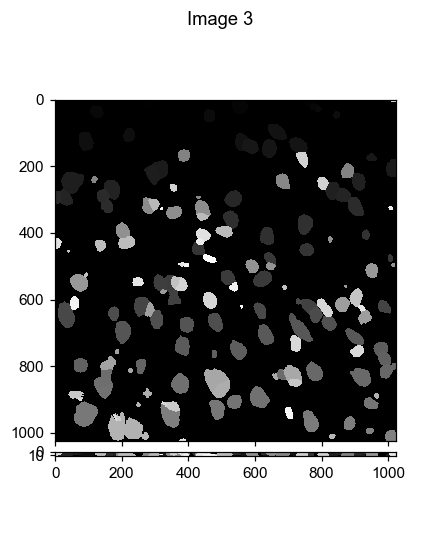

In [7]:
visual_tools.imshow_mark_3d_v2([test_dapi_im, test_polyt_im, labels3d])